In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.special import binom
from scipy.stats import chi2_contingency, mannwhitneyu, norm, t, ttest_ind

%matplotlib inline

## Discrete Metrics

When analyzing discrete metrics like click-through rate, we randomly expose visitors to one of two ad designs to see if there's a significant difference in effectiveness. This tests the hypothesis that both designs perform equally in generating clicks.

In [16]:
# Setting the random seed for reproducibility
np.random.seed(42)

# Generating click data for two ad versions
clicks_version_A = np.random.binomial(n=1, p=0.6, size=15)
clicks_version_B = np.random.binomial(n=1, p=0.4, size=19)

# Calculating the counts of clicks and no-clicks for both versions
click_counts_A, no_click_counts_A = np.bincount(clicks_version_A)
click_counts_B, no_click_counts_B = np.bincount(clicks_version_B)

# Constructing a contingency table from the click data
contingency_table = pd.DataFrame({
    'Version A': [click_counts_A, no_click_counts_A], 
    'Version B': [click_counts_B, no_click_counts_B]
}, index=['Clicked', 'Not Clicked'])

print("- Initial Observations:")
print(f"  - Version A Clicks: {clicks_version_A}")
print(f"  - Version B Clicks: {clicks_version_B}\n")
print("- Contingency Table:")
display(contingency_table)

- Initial Observations:
  - Version A Clicks: [1 0 0 1 1 1 1 0 0 0 1 0 0 1 1]
  - Version B Clicks: [0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1]

- Contingency Table:


,Version A,Version B
Clicked,7,15
Not Clicked,8,4


### Fisher's exact test

Since we have a 2x2 contingency table we can use Fisher's exact test to compute an exact p-value and test our hypothesis.

In [9]:
def calc_hypergeometric_dist(successes, total_successes, draws, total):
    """Calculates the hypergeometric distribution probability."""
    return binom(total_successes, successes) * binom(total - total_successes, draws - successes) / binom(total, draws)

def fishers_exact_test(cont_table):
    """Determines the Fisher's exact test probability for a contingency table."""
    (clicks_A, clicks_B), (no_clicks_A, no_clicks_B) = cont_table
    total_clicks = clicks_A + clicks_B
    total_views = clicks_A + no_clicks_A
    total = clicks_A + clicks_B + no_clicks_A + no_clicks_B
    return calc_hypergeometric_dist(clicks_A, total_clicks, total_views, total)

def histogram_fishers_test(cont_table):
    """Creates a probability mass function histogram based on Fisher's exact test."""
    min_neg = -min(contingency_table.values[0, 0], contingency_table.values[1, 1])
    max_pos = min(contingency_table.values[1, 0], contingency_table.values[0, 1])
    probabilities = []
    for shift in range(min_neg, max_pos + 1):
        adjusted_matrix = cont_table + np.array([[1, -1], [-1, 1]]) * shift
        probabilities.append(fishers_exact_test(adjusted_matrix))
    return probabilities


Fisher's Exact Test P-Value: 7.5%


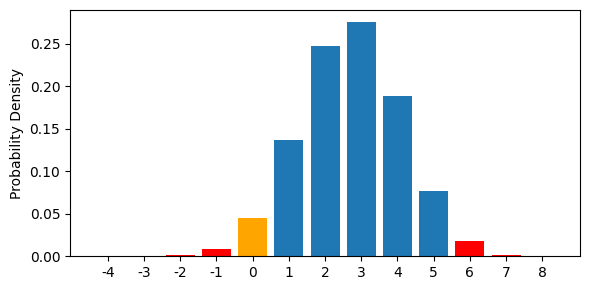

In [18]:

min_neg = -min(contingency_table.values[0, 0], contingency_table.values[1, 1])
max_pos = min(contingency_table.values[1, 0], contingency_table.values[0, 1])
# Running the Fisher's exact test histogram calculation
histogram_probs = np.array(histogram_fishers_test(contingency_table.values))

# Plotting the results
fig, axis = plt.subplots(figsize=(6, 3))
indexes = np.arange(len(histogram_probs))
axis.bar(indexes, histogram_probs)
highlighted_indexes = histogram_probs <= fishers_exact_test(contingency_table.values)
axis.bar(indexes[highlighted_indexes], histogram_probs[highlighted_indexes], color='red')
axis.set_ylabel("Probability Density")

# Calculating the p-value
p_value = histogram_probs[highlighted_indexes].sum()

# Highlighting the observed value's bar
axis.bar(indexes[-min_neg], histogram_probs[-min_neg], color='orange')
axis.set_xticks(indexes)
axis.set_xticklabels(np.arange(min_neg, max_pos + 1))
fig.tight_layout()

# Printing the p-value
print(f"Fisher's Exact Test P-Value: {100*p_value:.1f}%")

### Pearson's chi-squared test

Fisher's exact test has the important advantage of computing exact p-values. But if we have a large sample size, it may be computationally inefficient. In this case, we can use Pearson's chi-squared test to compute an approximate p-value.

In [19]:
# Performing the chi-squared test without the Yates' continuity correction
chi_squared_statistic, p_value_chi_squared = chi2_contingency(contingency_table.values, correction=False)[:2]

# Displaying the results of the chi-squared test
print("- Pearson's Chi-Squared Test Results:")
print(f"   - Chi-Squared Statistic: {chi_squared_statistic:.3f}")
print(f"   - P-Value: {p_value_chi_squared*100:.1f}%")

- Pearson's Chi-Squared Test Results:
   - Chi-Squared Statistic: 3.825
   - P-Value: 5.1%


## Continuous Metrics

In examining continuous metrics, such as the average revenue per user, the focus shifts to assessing the financial impact of different website layouts on user spending. By randomly presenting one of two product layout designs to website visitors, and tracking the monthly revenue generated from each user, the goal is to evaluate if there's a significant difference in revenue efficiency between the two layouts. This approach tests the null hypothesis, which posits that both layouts perform equally in terms of revenue generation.

- Revenue Data Overview:
  - Layout A Revenue: [200 150 250 350 150 150 350 250 150 250 150 150 200   0   0 100  50]
  - Layout B Revenue: [300 150 150 400 250 250 150 200 250 150 300 200 250 200]

- Visualizing Revenue Distribution:


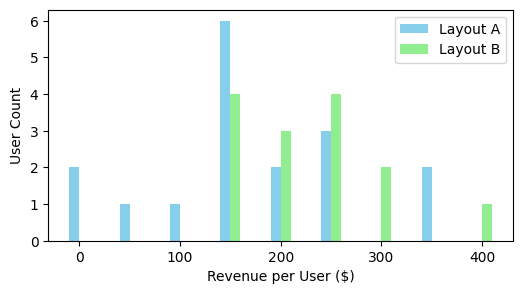

In [20]:
np.random.seed(42)

# Defining the sample sizes for both versions
sample_size_A, sample_size_B = 17, 14

# Creating distributions for both versions with specific mean and standard deviation
distribution_A = norm(loc=200, scale=100)
distribution_B = norm(loc=280, scale=90)

# Discretizing the revenue data to the nearest $50 for each version
discretization_interval = 50
revenue_A = (distribution_A.rvs(size=sample_size_A) / discretization_interval).astype(int) * discretization_interval
revenue_B = (distribution_B.rvs(size=sample_size_B) / discretization_interval).astype(int) * discretization_interval

# Printing the observed revenue values
print("- Revenue Data Overview:")
print(f"  - Layout A Revenue: {revenue_A}")
print(f"  - Layout B Revenue: {revenue_B}\n")

# Plotting the distribution of purchase values
print("- Visualizing Revenue Distribution:")
fig, axis = plt.subplots(figsize=(6, 3))
labels = ["Layout A", "Layout B"]
colors = ["skyblue", "lightgreen"]
for index, (revenue, label, color) in enumerate(zip([revenue_A, revenue_B], labels, colors)):
    values, counts = np.unique(revenue, return_counts=True)
    axis.bar(values - 5 + 10 * index, counts, width=10, label=label, color=color)

axis.set_xlabel("Revenue per User ($)")
axis.set_ylabel("User Count")
axis.legend()
plt.show()

In [22]:
def plot_p_value(distribution, test_statistic, x_limits=(-5, 5), y_limits=(0, 0.5)):
    # Generating a range of x values for plotting the distribution
    x_values = np.linspace(x_limits[0], x_limits[1], 1000)
    figure, axis = plt.subplots(figsize=(4, 3))
    
    # Plotting the probability density function (PDF) of the distribution
    axis.plot(x_values, distribution.pdf(x_values))
    axis.set_ylim(y_limits)
    
    # Drawing a vertical line and point at the test statistic value
    axis.vlines(test_statistic, 0, distribution.pdf(test_statistic), color='orange')
    axis.plot(test_statistic, distribution.pdf(test_statistic), 'o', color='orange')
    
    # Highlighting the critical region in the tail(s) where x <= test statistic
    left_tail = x_values <= test_statistic
    axis.fill_between(x_values[left_tail], 0, distribution.pdf(x_values[left_tail]), color='red')
    
    # Highlighting the critical region in the tail(s) where x >= -test statistic
    right_tail = x_values >= -test_statistic
    axis.fill_between(x_values[right_tail], 0, distribution.pdf(x_values[right_tail]), color='red')
    
    axis.set_ylabel("Probability Density")
    figure.tight_layout()
    
    return figure, axis

### Z-test

The Z-test can be applied under the following assumptions:
* The observations are normally distributed (or the sample size is large).
* The sampling distributions have known variance σ_X and σ_Y.

Under the above assumptions, the Z-test relies on the observation that the following Z statistic has a standard normal distribution.

- Z-test:
   - z value: -1.697
   - p-value: 9.0%


(<Figure size 400x300 with 1 Axes>, <Axes: ylabel='Probability Density'>)

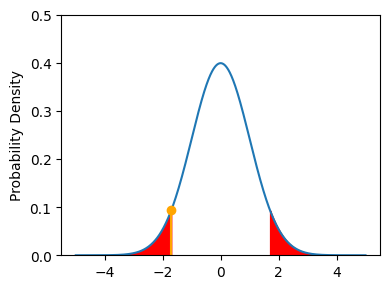

In [27]:
# Known standard deviations
s_x = 100
s_y = 90

# Calculating the Z value
z_val = (revenue_A.mean() - revenue_B.mean()) / np.sqrt(s_x**2 / sample_size_A + s_y**2 / sample_size_B)

# Test statistic distribution under the null hypothesis H0 (standard normal distribution)
stat_distrib = norm(loc=0, scale=1)

# p-value
p_val = stat_distrib.cdf(z_val) * 2

print("- Z-test:")
print(f"   - z value: {z_val:.3f}")
print(f"   - p-value: {p_val*100:.1f}%")
plot_p_value(stat_distrib, z_val)

### Welch's Test

Welch's t-test is used when two sample groups have unequal variances, modifying the standard t-test to accommodate this variance difference. It calculates a distinct degrees of freedom, ensuring accurate comparison of means even when the assumption of equal variances is not met.

- Welch' t-test:
   - nu: 28.505
   - t value: -1.848
   - p-value: 7.5%


(<Figure size 400x300 with 1 Axes>, <Axes: ylabel='Probability Density'>)

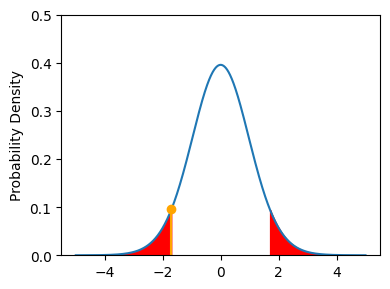

In [29]:
# Sample variances (w. Bessel correction)
s_x = np.sqrt(np.var(revenue_A, ddof=1))
s_y = np.sqrt(np.var(revenue_B, ddof=1))

# Denominator (not a pooled variance!)
s_d = np.sqrt(s_x**2/sample_size_A + s_y**2/sample_size_B)

    
# Test statistic distribution under null hypothesis H0
dofs = s_d**4 / ((s_x**2/sample_size_A)**2/(sample_size_A-1) +
                 (s_y**2/sample_size_B)**2/(sample_size_B-1))
stat_distrib = t(df=dofs, loc=0, scale=1)

# t value
t_val = (revenue_A.mean() - revenue_B.mean()) / s_d

# p-value
p_val = stat_distrib.cdf(t_val) * 2

print("- Welch' t-test:")
print(f"   - nu: {dofs:.3f}")
print(f"   - t value: {t_val:.3f}")
print(f"   - p-value: {p_val*100:.1f}%")
plot_p_value(stat_distrib, z_val)

### Mann-Whitney U test

The Mann-Whitney U test, a nonparametric method, requires minimal assumptions about the data's distribution. It evaluates the U statistic to analyze if two independent samples likely originate from the same distribution. 

Under the null hypothesis, it assumes that the probability of a value from one sample being greater than a value from the other sample is equal to the probability of it being less. This test is particularly useful when dealing with non-normal distributions or unequal variances between groups.

In [30]:
mwu = mannwhitneyu(revenue_A, revenue_B, use_continuity=False, alternative="two-sided")

print("- Mann-Whitney U test:")
print(f"   - U value: {mwu.statistic:.3f}")
print(f"   - p-value: {mwu.pvalue*100:.1f}%")

- Mann-Whitney U test:
   - U value: 76.000
   - p-value: 8.0%
